# <center> $ Machine \; Learning  $ <br> <center> $ Free-Sound \; Audio \; Tagging \; Project $  
### <center> $ A \; test \; algorithm \; for \; tagging \; audio \; data \; automatically. $ <br><br> <center> $ By \; processing \; sound \; wave \; Files\; and \; generating \; relevant \; signal \; Features $ <br> <center> $ Aimed \; at \; identifing \; a \;diverse \; vocabulary \; of \; categories \; such \; as: $ <br> <center> &#9733; $ Dog \; bark $ &#9733; $ Bibycle \; bell $ &#9733; <br> <center> &#9733; $ Car \; passing \; by $ &#9733; $ Bus \; sound $ &#9733; $ Human \; speaking \; sound $ &#9733;
<center> ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

<img src="soundWave.png" style="width: 600px; height:200px"/>

### &#128218; $ Project \; Dataset \; from \; kaggle \; competition $ 
&#10004; Audio Dataset, manually-labeled data (Curated subset.csv) containing a vocabulary of 80 labels of diverse topics such as: <br> &emsp; &emsp; Musical instruments, Human voice, Domestic animals, Water, Hands, Human actions, Insect, Motor vehicle (road) <br> 
&emsp; &emsp; In this project, seven labels were chosen to be processed.
<br> 
&#10004; train_curated_data: a large set of uncompressed PCM 16 bit, 44.1 kHz, mono audio clips (wav) files, with duration ranges from 0.3 to 30s.

# $ Project \; milestones $ &#128373;
### $1. Data \; Collection $
&emsp; &#9733; Select several categories (classes/tags) from csv file. <br>
&emsp; &#9733; Read all files labeled with each class - Including files with labels containing the class<br>
### $2. EDA  \; and  \; Features \; built $
&emsp; &#9733; Process wav files: <br>
&emsp;&emsp;&emsp;    - Calculate Mel-Frequency Cepstrum Coefficients (MFCCs) of the Pre-emphasis signal.<br>
&emsp;&emsp;&emsp;    - Split the signal into short-time frames ( frequencies in a signal are stationary over a very short period of time).<br>
&emsp;&emsp;&emsp;    - Apply a Hanning window function to each frame (better frequency acccuricy due to largest sidelobe removal).<br>
&emsp;&emsp;&emsp;    - Preform Fourier-Transform and Power Spectrum on each time frame.<br>
&emsp;&emsp;&emsp;    - Calulate the max frequency of each fft fram - list of freqs represents the entire signal.<br>
&emsp;&emsp;&emsp;    - Calculate statistic parameters<br>
&emsp; &#9733; Build a new dataset of all new features and save to csv file <br>
&emsp; &#9733; Exampled Plots of a wave file <br>
### $ 3. Apply \; Machine \; learning \; Models $ 
&emsp; &#9733; K-nearest neighbors (KNN) classifier <br>
&emsp; &#9733; Logistic Regression Model with GridSearchCV<br>
&emsp; &#9733; Random forest model <br>
&emsp; &#9733; Ensemble DecisionTreeClassifier with Bagging <br>

In [20]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import IPython.display as ipd
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import find_peaks
from scipy.fftpack import dct
from scipy.io import wavfile
from skimage import util
import scipy.signal as signal
from pandas import read_csv
import seaborn as sns
import scipy
import pandas as pd
import numpy as np
import pylab
import librosa
import librosa.display
import wave
import struct
import sklearn
plt.style.use('classic')
%matplotlib inline
# Set default font size
#plt.rcParams['font.size'] = 20
#pd.set_option('display.max_columns',60)
#plt.style.available

In [21]:
def printsig():
    print('fs_rate:',fs_rate, 'Channels:', audio_chnl, 'duration:',duration,'sec.', 'Ts:', Ts, 'time:',time,'time_len:',time_len)
    # Plot original Audio signal
    plt.figure(figsize=(10, 3))
    plt.plot(time, sig_o)
    plt.title('Origin wave signal')
    plt.ylabel('Amplitude')
    plt.xlabel('Time')
    plt.show() 
    plt.figure(figsize=(10, 3))
    plt.plot(time, sig_s)
    plt.title('windowed wave signal')
    plt.ylabel('Amplitude')
    plt.xlabel('Time')
    plt.show() 

In [22]:
def print_mfcc():
    # Plot mfcc - the amplitude envelope of a waveform.
    plt.figure(figsize=(10, 3)) 
    librosa.display.waveplot(mfcc, sr=fs_rate)
    plt.title('mfcc envelope')
    plt.ylabel('Envelope Amplitude')
    plt.show()    
    # Plot mfcc spectrum.
    plt.figure(figsize=(10, 3))
    plt.title('mfcc spectogram')
    mfcc_spec=librosa.feature.mfcc(y=sig_s, sr=fs_rate)
    mfcc_spec=sklearn.preprocessing.scale(mfcc_spec, axis=1)
    librosa.display.specshow(mfcc_spec, sr=fs_rate, x_axis='time') 
    plt.show()     

In [23]:
def print_fft(sigfft,sigfreqs):
    # plot fft of signal
    plt.figure(figsize=(10, 3))
    plt.plot(sigfreqs,sigfft) 
    plt.title('FFT of signal')
    plt.ylabel('Power')
    plt.xlabel('Frequency')
    plt.show() 

    plt.figure(figsize=(10, 3))
    l=int(len(sigfft)/2)
    plt.plot(sigfreqs[1:l],sigfft[1:l]) 
    plt.title('positive FFT of signal')
    plt.ylabel('Power')
    plt.xlabel('Frequency')
    plt.show()  

In [24]:
def print_spectogram():
    frqs, times, xsig = signal.spectrogram(sig_s, fs_rate,  nperseg=1024,  # window='hamming',
                                       noverlap = 1024-256,detrend=False, scaling='spectrum')
    plt.figure(figsize=(10,5));
    plt.pcolormesh(times, frqs/1000, 20*np.log10(xsig), cmap='viridis' ) #viridis  magma  
    plt.title('Signal Spectrogram')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [kHz]');
    plt.show()  

In [25]:
def find_N(N_len):
    return 2**14 if N_len>=2**14 else N_len

In [26]:
def process_fft():
    #entire signal 
    N=find_N(time_len)
    #N=time_len
    fftsig= np.fft.fft(sig,N)
    sigfft=np.abs(fftsig)
    sigfreqs = np.fft.fftfreq(N,Ts)

    # slice signal to small frames
    frame_len = 1024 # about 20msec
    frame_time = Ts
    frames = util.view_as_windows(sig, window_shape=(frame_len,), step=512) #step=128)
    win = np.hanning(frame_len+1)[:-1]   # to try with hamming as well
    frames = frames*win
    frames = frames.T
    num_of_frames=frames.shape[0]
    #print(f'Signal shape: {sig.shape}, framed signal shape: {frames.shape[1]}')
    spects= np.fft.fft(frames, n=frame_len, axis=0)
    spects=np.abs(spects)
    #max_pwr = spects.max()
    frame_f = np.fft.fftfreq(frame_len,frame_time) #scipy.fftpack.fftfreq(frame_len,frame_time)
    pos=int(frame_len/2)
    max_val = np.amax(spects) # find fft max value    
            
    for x in range(frames.shape[1]):      
        idxs = np.argmax(spects[:pos,x])   # index of max peak in frame :pos
        if spects[idxs,x] > (0.5 * max_val): # 0.65
            sig_freqs.append(frame_f[idxs])  # create a list of frequencies in each frame        

#         if fname=='962ffc01.wav':#3315ec7f.wav 0006ae4e 6459fc05 
#             print('column', x)
#             print(f'maximum value in column {x} {np.amax(spects[:pos,x])}')
#             print(f'the idxs {idxs} with the value  of {spects[idxs,x]}') 
    
    # prints and plots a single wave file
    if fname=='074a72f0.wav':  # 6459fc05 / 3315ec7f / 962ffc01.wav  / 54073d7e / d41f1ae5.wav
        print('File: 074a72f0.wav, Labled: Bicycle bell ')  
        printsig()
        print_mfcc()
        print_fft(sigfft,sigfreqs)
        print_spectogram()
        #print('max val',max_val)
        print(f'sig_freqs: {sig_freqs}')
        
    static_feats=[np.mean(sig_freqs), np.median(sig_freqs),np.std(sig_freqs),np.var(sig_freqs),
                  min(sig_freqs), max(sig_freqs)]

    return static_feats

## $ 1. \; Data \; Collection $ &#128204;

In [29]:
# main classes to process and their files

#df_submission = pd.read_csv("Freesound\sample_submission.csv",  encoding='utf-8-sig') 
#classes = sorted(set(list(df_submission[1:])[1:]))     

#Selected categiries to process
classes = ['Bark','Bass_drum','Bicycle_bell','Bus','Car_passing_by','Male_speech_and_man_speaking',
           'Male_speech_and_man_speaking,Male_singing','Female_speech_and_woman_speaking','Female_speech_and_woman_speaking,Whispering']

# Reading wave files name
df_train_curated = pd.read_csv("Freesound/train_curated.csv")  
# Creating file names df for selected categories
df_train_curated = df_train_curated.loc[df_train_curated['labels'].isin(classes)]
df_files = df_train_curated.copy()
df_files.sort_values('labels', ascending=True, inplace=True);
df_files = df_files.reset_index(drop=True)
print(f'From dataset: {len(df_files)} Sound files')
df_files.head()

From dataset: 446 Sound files


,fname,labels
0,0006ae4e.wav,Bark
1,4be092c8.wav,Bark
2,4d135390.wav,Bark
3,4e5c0a8a.wav,Bark
4,e20b02c1.wav,Bark


In [30]:
# combine Male / Female voices
classes = classes[:-2]
classes[-2]='Male_voice'
classes[-1]='Female_voice'
male = dict.fromkeys(['Male_speech_and_man_speaking','Male_speech_and_man_speaking,Male_singing'], 'Male_voice')    
female = dict.fromkeys(['Female_speech_and_woman_speaking','Female_speech_and_woman_speaking,Whispering'],'Female_voice')  
df_files = df_files.replace(male)
df_files = df_files.replace(female)
classes

['Bark',
 'Bass_drum',
 'Bicycle_bell',
 'Bus',
 'Car_passing_by',
 'Male_voice',
 'Female_voice']

In [31]:
#find the number of files for each class
for cls in classes: 
    files_len=len(df_files[df_files.labels==cls])  # The number of files 
    print(cls, files_len, 'files')

Bark 69 files
Bass_drum 68 files
Bicycle_bell 67 files
Bus 70 files
Car_passing_by 62 files
Male_voice 62 files
Female_voice 48 files


## $ 2. \; EDA \; and \; Data \; features \; generation $ &#128204;

In [32]:
# New features dataframe
features_df = pd.DataFrame(columns=['file_name', 'avrg_freq','med_freq','std_Freq','var_freq',
                                    'min_freq', 'max_freq',
                                    'mfcc1','mfcc2','mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8',
                                    'mfcc9','mfcc10','mfcc11','mfcc12','class',]) 
corruptedFiles=['67c4bcf4.wav','f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav', '962ffc01.wav']

File: 074a72f0.wav, Labled: Bicycle bell 
fs_rate: 44100 Channels: 1 duration: 5.801020408163265 sec. Ts: 2.2675736961451248e-05 time: [0.00000000e+00 2.26758256e-05 4.53516512e-05 ... 5.80097506e+00
 5.80099773e+00 5.80102041e+00] time_len: 255825


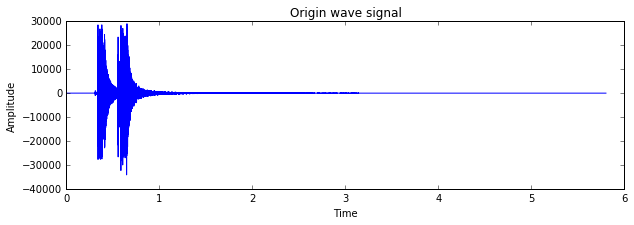

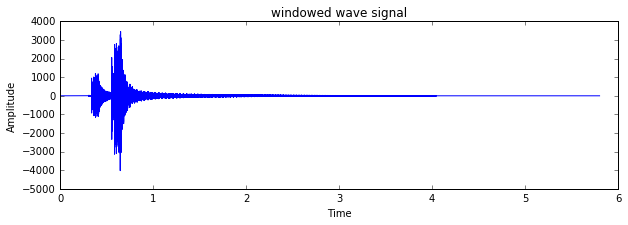

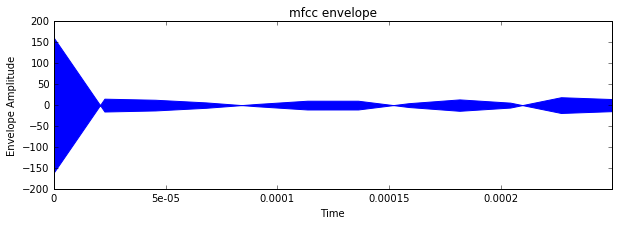

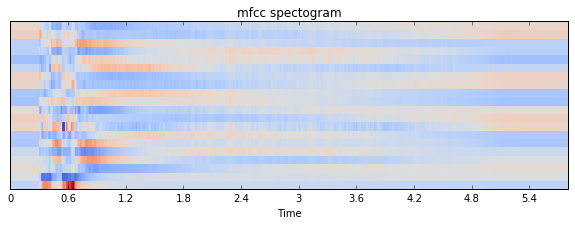

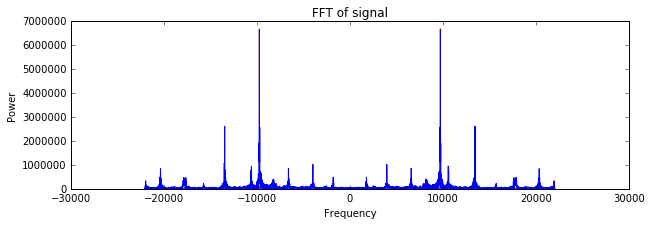

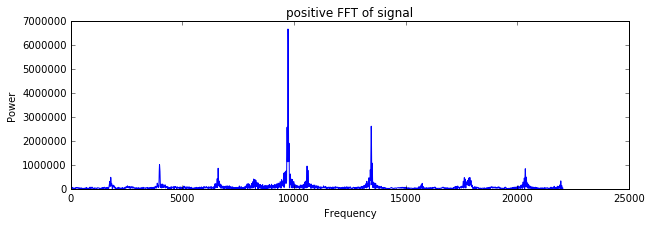

C:\Users\rutha\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


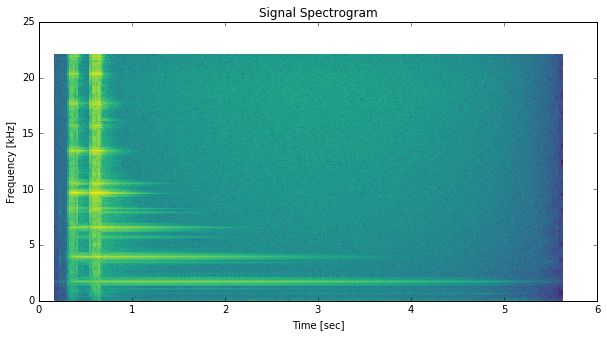

sig_freqs: [9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125, 9733.0078125]


In [33]:
for cls in classes: 
    fnames = df_files[df_files['labels']==cls].fname
    
    for fname in fnames: #i in range(len(fnames)-1): 
        if fname not in corruptedFiles:
            # Reading wav files
            fs_rate, sig = scipy.io.wavfile.read('Freesound/train_curated_data/'+fname)
            duration = len(sig) / fs_rate
            audio_chnl = len(sig.shape)    # number of Channels
            Ts = 1.0 / fs_rate            # Timestep between samples
            time=np.linspace(0, duration, num = len(sig), endpoint=True)
            time_len = len(time)

            fltr_coef = 0.97 # filter coefficiant typical value
            sig_o = np.append(sig[0], sig[1:] - fltr_coef * sig[:-1])  #  floating point

            sig_freqs = []
            static_feats = []

            # windowing the signal
            wind = np.hanning(len(sig)+1)[:-1]  
            sig_s  = sig_o * wind

            # mel-frequency ceptral coefficiens
            mfcc = np.mean(librosa.feature.mfcc(y=sig_s, sr=fs_rate, n_mfcc=12).T,axis=0)

            static_feats = process_fft()   # wave processing in the frequency domain

            features_df.loc[len(features_df)] = [fname]+list(static_feats)+list(mfcc)+[cls]   

### Clean data and save to csv file &#11088;

In [34]:
# delete outliers
features_df=features_df[features_df['max_freq']>0]    

# replace empty features
map_std=features_df[features_df['std_Freq']>0].groupby('class')['std_Freq'].mean()
map_var=features_df[features_df['var_freq']>0].groupby('class')['var_freq'].mean()

features_df.loc[features_df['std_Freq']==0,'std_Freq'] = features_df[features_df['std_Freq']==0]\
                                                         .apply(lambda df_row: map_std.loc[df_row['class']], axis=1)

features_df.loc[features_df['var_freq']==0,'var_freq'] = features_df[features_df['var_freq']==0]\
                                                         .apply(lambda r: map_var.loc[r['class']], axis=1)

features_df.loc[features_df['min_freq']==0,'min_freq'] = features_df[features_df['min_freq']==0]\
                                                         .apply(lambda r: map_var.loc[r['class']], axis=1)

features_df.loc[features_df['med_freq']==0,'med_freq'] = features_df[features_df['med_freq']==0]\
                                                         .apply(lambda r: map_var.loc[r['class']], axis=1)

# Save all features in csv file
features_df.to_csv('features.csv', encoding='utf-8') #  (index=False)

b_s = '\033[1m'
b_e = '\033[0m'
print(b_s,'\033[34m ......{} files were recorded in features.csv'.format(len(features_df.file_name)),b_e)

  ......432 files were recorded in features.csv 


##  &#128266; Play Audio 

In [35]:
ipd.Audio('Freesound/train_curated_data/074a72f0.wav')    # Bicycle Bell

In [36]:
ipd.Audio('Freesound/train_curated_data/d41f1ae5.wav')  # Male speaking

In [37]:
features_df.describe()

,avrg_freq,med_freq,std_Freq,var_freq,min_freq,max_freq,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
count,432.000000,4.320000e+02,432.000000,4.320000e+02,4.320000e+02,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,1731.349857,1.330712e+04,494.383922,1.129555e+06,7.697954e+04,2589.467367,377.178734,25.064983,-17.660503,5.442330,-7.524895,8.502181,-5.765169,2.571340,0.052863,-0.434237,0.124407,3.168230
std,3204.791382,1.322377e+05,874.514837,3.486425e+06,5.151461e+05,4036.283838,210.541575,51.792791,30.461865,26.045833,21.161912,14.365029,15.968009,12.611651,10.309275,10.901619,8.649240,7.854926
min,4.306641,2.153320e+01,6.565704,4.310846e+01,4.306641e+01,43.066406,-714.379535,-154.912425,-120.625434,-63.300400,-63.976065,-49.920754,-69.451760,-43.290449,-37.355557,-31.305671,-24.374103,-32.203024
25%,129.199219,1.291992e+02,33.380961,1.272612e+03,8.613281e+01,258.398438,290.143897,-11.116077,-34.308656,-11.548915,-18.414014,-1.442330,-15.628493,-5.955513,-6.104267,-6.214001,-5.494577,-0.817942
50%,469.521706,4.737305e+02,117.663851,1.471911e+04,4.306641e+02,775.195312,407.036598,35.357720,-16.287498,8.309735,-6.552201,7.877057,-4.079712,2.047811,-0.084662,0.167319,-0.195802,3.379070
75%,835.227273,9.474609e+02,379.838954,1.465242e+05,4.005176e+03,1905.688477,506.985301,63.467112,-0.110483,21.878751,4.800084,17.215874,4.515555,10.483553,6.576666,5.643256,5.428360,8.094331
max,16760.009766,1.932500e+06,6890.625000,4.748071e+07,5.594696e+06,20456.542969,720.246347,196.092543,80.789375,84.006361,60.900366,52.847150,39.121736,39.295929,33.172674,32.882031,26.409902,22.934497


## View Features & Classes Correlations &#128526;

In [38]:
df_dumm = pd.get_dummies(features_df[features_df.columns[2:]])  # Create class dummies
df_dumm.head()

,med_freq,std_Freq,var_freq,min_freq,max_freq,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc10,mfcc11,mfcc12,class_Bark,class_Bass_drum,class_Bicycle_bell,class_Bus,class_Car_passing_by,class_Female_voice,class_Male_voice
0,430.664062,174.251292,30363.512591,387.597656,904.394531,303.784478,66.394696,1.558475,-2.095553,-17.995065,...,3.885236,-1.637586,0.613085,1,0,0,0,0,0,0
1,602.929688,101.183144,10238.028717,602.929688,1119.726562,304.232527,63.922822,-13.333472,-29.750039,-39.952823,...,-24.347452,-3.326864,0.432651,1,0,0,0,0,0,0
2,689.062500,59.446079,3533.836342,559.863281,775.195312,369.773352,67.601353,-8.089479,-41.293279,-43.415329,...,-29.146071,-1.641885,2.157133,1,0,0,0,0,0,0
3,947.460938,107.661133,11590.919495,473.730469,1033.593750,354.803428,26.290453,-23.782127,-14.688434,-31.060271,...,-10.449725,-9.908524,-0.281396,1,0,0,0,0,0,0
4,602.929688,53.157724,2825.743604,602.929688,732.128906,322.439893,72.466072,-4.463127,-32.747208,-45.989441,...,-18.261353,-10.281818,8.204346,1,0,0,0,0,0,0


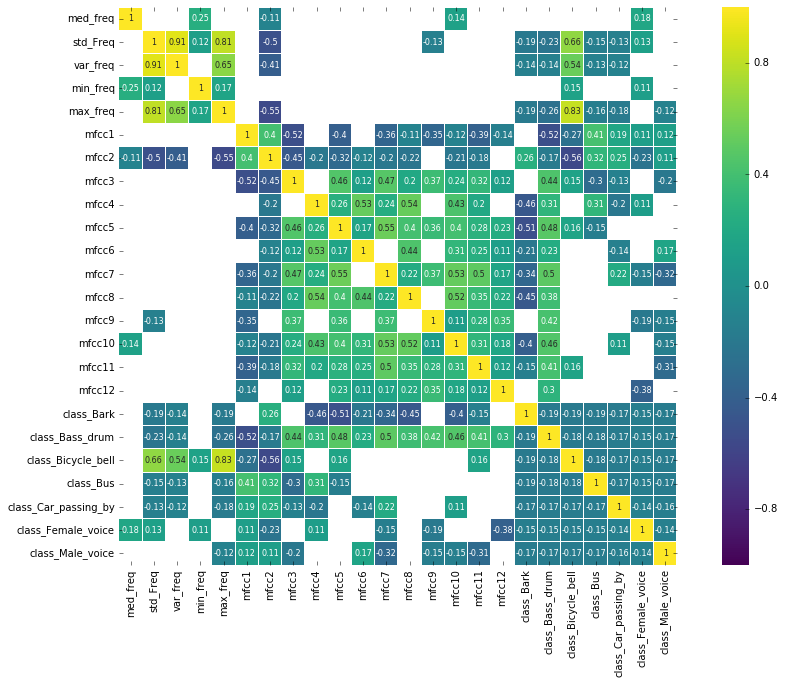

In [39]:
plt.figure(figsize=(16,10))
corr=df_dumm.corr()
sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
plt.show()

### &#128201; Distribution of sounds Vs. frequency

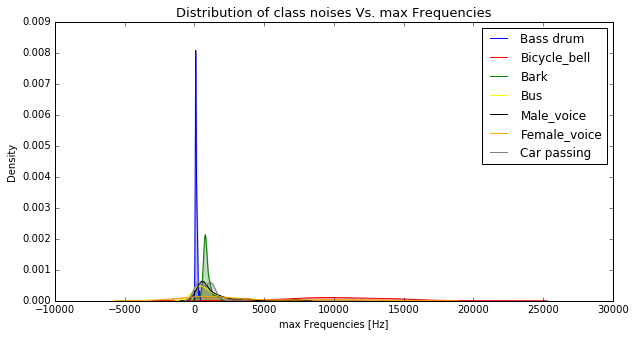

In [40]:
plt.figure(figsize=(10,5))
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Bass_drum'] == 1) ],
                color="blue", shade = True)
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Bicycle_bell'] == 1) ],
                ax =ax, color="red", shade= True)
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Bark'] == 1) ],
                ax =ax, color="green", shade= True)
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Bus'] == 1) ],
                ax =ax, color="yellow", shade= True)
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Male_voice'] == 1) ],
                ax =ax, color="black", shade= True)
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Female_voice'] == 1) ],
                ax =ax, color="orange", shade= True)
ax = sns.kdeplot(df_dumm.max_freq[(df_dumm['class_Car_passing_by'] == 1) ],
                ax =ax, color="grey", shade= True)
ax.legend(['Bass drum', 'Bicycle_bell', 'Bark','Bus','Male_voice','Female_voice','Car passing'], loc='best')
ax.set_ylabel('Density')
ax.set_xlabel('max Frequencies [Hz]')
ax.set_title('Distribution of class noises Vs. max Frequencies', size = 13);

# 3. Mechine Learning &#128204;

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score,\
    GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
np.random.seed(0)

In [42]:
def classification_results(y, y_pred, name='', add_rep=True):  # False
    acc = accuracy_score(y, y_pred)
                        
    cm = pd.DataFrame(confusion_matrix(y, y_pred), 
                      index=classes, 
                      columns=classes)

    print(name + ' accuracy: ', round(acc,4),'\n') # round(acc,4)
    print(cm,'\n')
    if (add_rep):
        print(classification_report(y, y_pred))

In [43]:
df = read_csv("features.csv")
train, test = train_test_split(df, test_size=0.3,  random_state=0)  #, random_state=0
train.shape

(302, 21)

In [44]:
X_train = train[train.columns[2:-1]]
y_train = train[train.columns[-1]]
X_test = test[test.columns[2:-1]]
y_test = test[test.columns[-1]]

## K-nearest neighbors (KNN) classifier &#129353;

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import QuantileTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, precision_score 

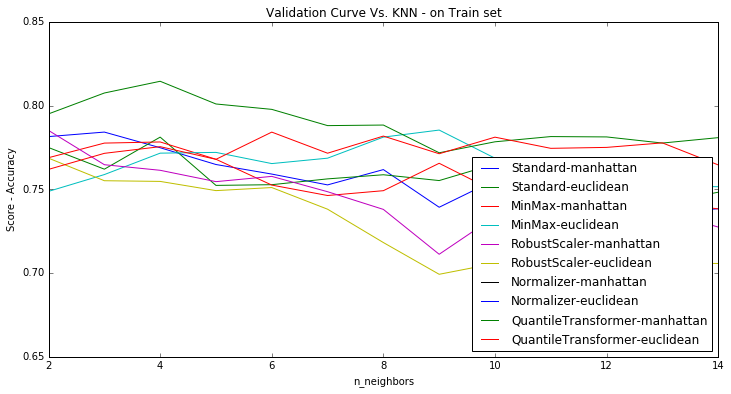

In [49]:
scalers =np.array( [['Standard', StandardScaler()], 
                   ['MinMax', MinMaxScaler()], 
                   ['RobustScaler', RobustScaler()],
                   ['Normalizer' , Normalizer()],
                   ['QuantileTransformer', QuantileTransformer(n_quantiles=len(X_train))]])

plt.figure(figsize=(12, 6))
legend =[]
for [scaler_name, scaler_func] in scalers:
    for metric in ['manhattan', 'euclidean']:    #'hamming'
        scaler = scaler_func
        scaler.fit(X_train)
        X = scaler.transform(X_train) 
        y = y_train
        param='n_neighbors'
        param_range = range(2,15,1)
        train_scores, test_scores = validation_curve(KNeighborsClassifier(metric=metric),
                                                     X, y,                                        
                                                     param_name=param,
                                                     param_range=param_range,
                                                     scoring="accuracy",
                                                     cv=5) 
        
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.plot(param_range, test_scores_mean);
        legend.append(scaler_name+'-'+metric)

    plt.title("Validation Curve Vs. KNN - on Train set")
    plt.xlabel(param)
    plt.ylabel("Score - Accuracy")
    plt.ylim(0.65, 0.85)      
    plt.legend(legend, loc='lower right')
plt.show()

In [50]:
knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan')   #6,euclidean manhattan

# Scale Transform and normalization   
scaler = QuantileTransformer(n_quantiles=len(X_train)).fit(X_train)   # 

X = scaler.transform(X_train)  
y = y_train

knn.fit(X, y);

In [51]:
y_train_pred = knn.predict(X)
cm = confusion_matrix(y_true=y, y_pred=y_train_pred)
print('\nConfusion matrix on Train set:\n')
pd.DataFrame(cm, index=knn.classes_, columns=knn.classes_)


Confusion matrix on Train set:



,Bark,Bass_drum,Bicycle_bell,Bus,Car_passing_by,Female_voice,Male_voice
Bark,41,1,0,0,1,0,0
Bass_drum,0,50,0,0,0,0,0
Bicycle_bell,0,0,41,0,0,0,1
Bus,2,1,2,45,3,0,0
Car_passing_by,0,0,0,6,35,0,0
Female_voice,2,0,1,3,2,24,0
Male_voice,6,0,0,2,1,2,30


In [52]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('\nConfusion matrix on Train set:\n',cm)

print('\nClassification_report on Train set\n',classification_report(y_true=y, y_pred=y_train_pred))


Confusion matrix on Train set:
 [[0.95348837 0.02325581 0.         0.         0.02325581 0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.97619048 0.         0.         0.
  0.02380952]
 [0.03773585 0.01886792 0.03773585 0.8490566  0.05660377 0.
  0.        ]
 [0.         0.         0.         0.14634146 0.85365854 0.
  0.        ]
 [0.0625     0.         0.03125    0.09375    0.0625     0.75
  0.        ]
 [0.14634146 0.         0.         0.04878049 0.02439024 0.04878049
  0.73170732]]

Classification_report on Train set
                 precision    recall  f1-score   support

          Bark       0.80      0.95      0.87        43
     Bass_drum       0.96      1.00      0.98        50
  Bicycle_bell       0.93      0.98      0.95        42
           Bus       0.80      0.85      0.83        53
Car_passing_by       0.83      0.85      0.84        41
  Female_voice       0.92      0.75      0.83        32
    Male

In [53]:
X_test_knn = scaler.transform(X_test) 
y_test_pred = knn.predict(X_test_knn)

In [54]:
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print('\nConfusion matrix on Test set:\n')
pd.DataFrame(cm, index=knn.classes_, columns=knn.classes_)


Confusion matrix on Test set:



,Bark,Bass_drum,Bicycle_bell,Bus,Car_passing_by,Female_voice,Male_voice
Bark,23,0,0,1,2,0,0
Bass_drum,0,17,0,0,0,0,0
Bicycle_bell,0,0,24,0,0,0,0
Bus,2,2,1,8,0,0,0
Car_passing_by,0,4,0,0,13,1,0
Female_voice,4,2,1,0,0,8,1
Male_voice,2,0,0,0,2,3,9


In [55]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('\nConfusion matrix on Test set:\n',cm)
print ('\nClassification_report on Test set\n',classification_report(y_true=y_test, y_pred=y_test_pred))


Confusion matrix on Test set:
 [[0.88461538 0.         0.         0.03846154 0.07692308 0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.15384615 0.15384615 0.07692308 0.61538462 0.         0.
  0.        ]
 [0.         0.22222222 0.         0.         0.72222222 0.05555556
  0.        ]
 [0.25       0.125      0.0625     0.         0.         0.5
  0.0625    ]
 [0.125      0.         0.         0.         0.125      0.1875
  0.5625    ]]

Classification_report on Test set
                 precision    recall  f1-score   support

          Bark       0.74      0.88      0.81        26
     Bass_drum       0.68      1.00      0.81        17
  Bicycle_bell       0.92      1.00      0.96        24
           Bus       0.89      0.62      0.73        13
Car_passing_by       0.76      0.72      0.74        18
  Female_voice       0.67      0.50      0.57        16
    Mal

## Data Normalization

In [56]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [57]:
train.head()

,Unnamed: 0,file_name,avrg_freq,med_freq,std_Freq,var_freq,min_freq,max_freq,mfcc1,mfcc2,...,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,class
364,372,3de5d57e.wav,1195.092773,1227.392578,102.706833,10548.693538,1076.660156,1378.125000,476.966314,83.382298,...,-55.116081,-33.827867,-19.192161,-9.511131,14.019140,-0.922378,-2.736542,2.233543,8.640794,Male_voice
106,106,edeea125.wav,86.132812,86.132812,33.380961,1413.489450,86.132812,86.132812,54.420035,-22.795461,...,30.044726,21.395752,20.762084,20.362431,19.326247,18.654052,16.432023,14.600736,12.492035,Bass_drum
272,277,e3ca796e.wav,560.536194,559.863281,310.928585,96676.584666,129.199219,1464.257812,504.334884,71.587948,...,-23.817059,-10.799532,-5.642739,10.579085,-0.345687,0.692451,0.413720,3.233855,4.905127,Car_passing_by
63,63,a0a09b04.wav,882.861328,947.460938,315.605204,99606.644674,516.796875,1636.523438,409.950134,71.751351,...,-39.286293,-59.179974,4.047488,-19.099687,-17.832308,9.689482,-20.898138,-14.393885,3.442658,Bark
298,305,706ffa7c.wav,145.175466,129.199219,81.211085,6595.240396,43.066406,301.464844,439.308046,78.684060,...,18.813908,1.187902,15.334813,1.087264,6.126798,-1.192344,-0.414467,-0.073922,-4.726802,Car_passing_by


In [58]:
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

## Logistic Regression Model &#129353;

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=600, random_state=0)
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 600,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [61]:
clf_gs = GridSearchCV(clf, 
                      param_grid={'C': [0.01, 0.1, 1, 5, 10, 25, 50, 75, 100]},
                      iid=False,
                      cv=5)

clf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=600, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 25, 50, 75, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [62]:
print ("Best model:", clf_gs.best_estimator_)
print ("Best parameters:", clf_gs.best_params_)
print ("Best score:", clf_gs.best_score_)

Best model: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best parameters: {'C': 100}
Best score: 0.8377495828698553


In [74]:
clf = LogisticRegression(C=100, solver='liblinear', multi_class='ovr', max_iter=600, random_state=0)
clf.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 600,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [75]:
clf.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [76]:
print (clf.score(X_train, y_train))
print (clf.score(X_test, y_test))

0.9039735099337748
0.7538461538461538


In [77]:
y_pred=clf.predict(X_train)
print('train set accuracy=', accuracy_score(y_train, y_pred),'\n')

print(classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
cm

train set accuracy= 0.9039735099337748 

                precision    recall  f1-score   support

          Bark       0.98      0.93      0.95        43
     Bass_drum       0.94      0.94      0.94        50
  Bicycle_bell       0.98      1.00      0.99        42
           Bus       0.85      0.87      0.86        53
Car_passing_by       0.85      0.83      0.84        41
  Female_voice       0.90      0.88      0.89        32
    Male_voice       0.84      0.88      0.86        41

      accuracy                           0.90       302
     macro avg       0.90      0.90      0.90       302
  weighted avg       0.90      0.90      0.90       302



array([[40,  1,  0,  0,  0,  1,  1],
       [ 0, 47,  0,  1,  1,  0,  1],
       [ 0,  0, 42,  0,  0,  0,  0],
       [ 0,  0,  0, 46,  3,  2,  2],
       [ 0,  0,  0,  6, 34,  0,  1],
       [ 0,  1,  1,  0,  0, 28,  2],
       [ 1,  1,  0,  1,  2,  0, 36]], dtype=int64)

In [78]:
y_pred=clf.predict(X_test)
print('test set accuracy=', accuracy_score(y_test, y_pred),'\n')

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm

test set accuracy= 0.7538461538461538 

                precision    recall  f1-score   support

          Bark       0.76      0.85      0.80        26
     Bass_drum       0.77      1.00      0.87        17
  Bicycle_bell       1.00      0.88      0.93        24
           Bus       0.69      0.69      0.69        13
Car_passing_by       0.88      0.78      0.82        18
  Female_voice       0.56      0.56      0.56        16
    Male_voice       0.46      0.38      0.41        16

      accuracy                           0.75       130
     macro avg       0.73      0.73      0.73       130
  weighted avg       0.75      0.75      0.75       130



array([[22,  0,  0,  1,  1,  0,  2],
       [ 0, 17,  0,  0,  0,  0,  0],
       [ 1,  0, 21,  0,  0,  1,  1],
       [ 2,  1,  0,  9,  0,  1,  0],
       [ 0,  1,  0,  2, 14,  0,  1],
       [ 2,  2,  0,  0,  0,  9,  3],
       [ 2,  1,  0,  1,  1,  5,  6]], dtype=int64)

## Random forest model &#129352;
A technique that addes verasity to its models, by choosing a different subset of features as well for each bootstrapped sample to make the splits while training


In [79]:
Rd = RandomForestClassifier(random_state=0)  #max_depth=6

In [80]:
clf_rd = GridSearchCV(Rd, 
                      param_grid={'max_depth': [4,5,6, 7, 8, 9, 10, 11,12],
                                 'n_estimators': [5,8,10,13,15,16,17,18,20,22,24]},
                      iid=False,
                      cv=8)

clf_rd.fit(X_train, y_train);

In [81]:
print ("Best model:", clf_rd.best_estimator_)
print ("Best parameters:", clf_rd.best_params_)
print ("Best score:", clf_rd.best_score_)

Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best parameters: {'max_depth': 7, 'n_estimators': 17}
Best score: 0.8269849031362189


In [82]:
Rd = RandomForestClassifier(max_depth=7,n_estimators=17,random_state=0)

In [83]:
Rd.fit(X_train, y_train)
classification_results(y_train, Rd.predict(X_train), name='Rd on Train:')

Rd on Train: accuracy:  0.9834 

                Bark  Bass_drum  Bicycle_bell  Bus  Car_passing_by  \
Bark              42          1             0    0               0   
Bass_drum          0         50             0    0               0   
Bicycle_bell       0          0            41    0               0   
Bus                0          0             0   53               0   
Car_passing_by     0          0             0    0              40   
Male_voice         0          0             0    0               0   
Female_voice       0          0             0    0               0   

                Male_voice  Female_voice  
Bark                     0             0  
Bass_drum                0             0  
Bicycle_bell             0             1  
Bus                      0             0  
Car_passing_by           0             1  
Male_voice              30             2  
Female_voice             0            41   

                precision    recall  f1-score   support

   

In [84]:
classification_results(y_test, Rd.predict(X_test), name='Rd on Test:')

Rd on Test: accuracy:  0.8 

                Bark  Bass_drum  Bicycle_bell  Bus  Car_passing_by  \
Bark              22          0             0    0               2   
Bass_drum          0         17             0    0               0   
Bicycle_bell       0          0            24    0               0   
Bus                2          1             0    8               2   
Car_passing_by     0          1             0    2              14   
Male_voice         2          0             0    0               0   
Female_voice       2          0             1    0               1   

                Male_voice  Female_voice  
Bark                     0             2  
Bass_drum                0             0  
Bicycle_bell             0             0  
Bus                      0             0  
Car_passing_by           1             0  
Male_voice               9             5  
Female_voice             2            10   

                precision    recall  f1-score   support

       

## Ensemble DecisionTreeClassifier with Bagging  &#129351;

 ### Bagging (Bootstrap Aggregation)

In [85]:
n=150
modl=10

trains = [train.sample(n) for i in range(modl)]  # random_state=0
Dts = [DecisionTreeClassifier(max_depth=9).fit(scalar.transform(trains[i][df.columns[2:-1]]),                                            
                                               trains[i][df.columns[-1]]) for i in range(modl)]
predictions=pd.DataFrame()
test_predictions=pd.DataFrame()

In [86]:
for i,Dt in enumerate(Dts): 
    predictions['Dt'+str(i)]  = Dt.predict(scalar.transform(trains[i][df.columns[2:-1]]))
    test_predictions['Dt'+str(i)] = Dt.predict(scalar.transform(test[test.columns[2:-1]]))
 

In [87]:
test_predictions['fname']=list(test['file_name'])
test_predictions['class']=list(test['class'])
test_predictions.head()

,Dt0,Dt1,Dt2,Dt3,Dt4,Dt5,Dt6,Dt7,Dt8,Dt9,fname,class
0,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,8cab1f21.wav,Bicycle_bell
1,Female_voice,Female_voice,Female_voice,Female_voice,Female_voice,Bark,Female_voice,Female_voice,Female_voice,Female_voice,08d21a2f.wav,Female_voice
2,Bark,Bark,Female_voice,Male_voice,Bark,Bark,Bark,Bark,Male_voice,Bark,fd6af2dd.wav,Bark
3,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,e440ec93.wav,Bicycle_bell
4,Bark,Bark,Bark,Male_voice,Bark,Female_voice,Bark,Bark,Male_voice,Bark,e7995482.wav,Bark


In [88]:
a = test_predictions[test_predictions.columns[2:]].mode(axis=1)
a=a[a.columns[0]]
test_predictions['pred']=a

In [89]:
test_predictions.head()

,Dt0,Dt1,Dt2,Dt3,Dt4,Dt5,Dt6,Dt7,Dt8,Dt9,fname,class,pred
0,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,8cab1f21.wav,Bicycle_bell,Bicycle_bell
1,Female_voice,Female_voice,Female_voice,Female_voice,Female_voice,Bark,Female_voice,Female_voice,Female_voice,Female_voice,08d21a2f.wav,Female_voice,Female_voice
2,Bark,Bark,Female_voice,Male_voice,Bark,Bark,Bark,Bark,Male_voice,Bark,fd6af2dd.wav,Bark,Bark
3,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,Bicycle_bell,e440ec93.wav,Bicycle_bell,Bicycle_bell
4,Bark,Bark,Bark,Male_voice,Bark,Female_voice,Bark,Bark,Male_voice,Bark,e7995482.wav,Bark,Bark


In [90]:
print('TestSet classification results:')
classification_results(y_test,test_predictions['pred'])

TestSet classification results:
 accuracy:  0.8231 

                Bark  Bass_drum  Bicycle_bell  Bus  Car_passing_by  \
Bark              24          0             0    1               0   
Bass_drum          0         17             0    0               0   
Bicycle_bell       0          0            24    0               0   
Bus                1          0             0    9               1   
Car_passing_by     0          1             0    2              14   
Male_voice         1          0             0    2               2   
Female_voice       1          1             0    0               1   

                Male_voice  Female_voice  
Bark                     0             1  
Bass_drum                0             0  
Bicycle_bell             0             0  
Bus                      1             1  
Car_passing_by           1             0  
Male_voice               9             2  
Female_voice             3            10   

                precision    recall  f1-

# <center> $ Thank \; you $ &#129488;

_______________________________________________________________________________________________